# Denoising Autoencoder

In [1]:
import logging

from fastai.basics import *
from fastai.callback.all import *
from fastai.torch_basics import *

from IPython.display import display

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import vaep
from vaep.io import datasplits
from vaep.models import ae
import vaep.models as models
import vaep.model
from vaep.analyzers import analyzers

# overwriting Recorder callback with custom plot_loss
from vaep.models import plot_loss
from fastai import learner

learner.Recorder.plot_loss = plot_loss


logger = vaep.logging.setup_logger(logging.getLogger('vaep'))
logger.info(
    "Experiment 03 - Analysis of latent spaces and performance comparisions")

figures = {}  # collection of ax or figures

vaep - INFO     Experiment 03 - Analysis of latent spaces and performance comparisions


In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
# training
epochs_max: int = 50  # Maximum number of epochs
# early_stopping:bool = True # Wheather to use early stopping or not
patience: int = 25  # Patience for early stopping
batch_size: int = 64  # Batch size for training (and evaluation)
cuda: bool = True  # Whether to use a GPU for training
# model
# Dimensionality of encoding dimension (latent space of model)
latent_dim: int = 25
# A underscore separated string of layers, '128_64' for the encoder, reverse will be use for decoder
hidden_layers: str = '512'

sample_idx_position: int = 0  # position of index which is sample ID
model: str = 'DAE'  # model name
model_key: str = 'DAE'  # potentially alternative key for model (grid search)
save_pred_real_na: bool = True  # Save all predictions for missing values
# metadata -> defaults for metadata extracted from machine data
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data

In [4]:
# Parameters
model = "DAE"
file_format = "csv"
latent_dim = 10
batch_size = 10
epochs_max = 200
hidden_layers = "512"
sample_idx_position = 0
cuda = False
save_pred_real_na = True
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
folder_experiment = "runs/dev_dataset_small/proteinGroups_N50"
model_key = "DAE"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/dev_dataset_small/proteinGroups_N50',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'epochs_max': 200,
 'patience': 25,
 'batch_size': 10,
 'cuda': False,
 'latent_dim': 10,
 'hidden_layers': '512',
 'sample_idx_position': 0,
 'model': 'DAE',
 'model_key': 'DAE',
 'save_pred_real_na': True,
 'meta_date_col': None,
 'meta_cat_col': None}

In [6]:
args = vaep.nb.args_from_dict(args)

if isinstance(args.hidden_layers, str):
    args.overwrite_entry("hidden_layers", [int(x)
                         for x in args.hidden_layers.split('_')])
else:
    raise ValueError(
        f"hidden_layers is of unknown type {type(args.hidden_layers)}")
args

{'batch_size': 10,
 'cuda': False,
 'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'epochs_max': 200,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'hidden_layers': [512],
 'latent_dim': 10,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'DAE',
 'model_key': 'DAE',
 'out_figures': Path('runs/dev_dataset_small/proteinGroups_N50/figures'),
 'out_folder': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_metrics': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_models': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_preds': Path('runs/dev_dataset_small/proteinGroups_N50/preds'),
 'patience': 25,
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/dev_dataset_small/proteinGroups_N50/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X.sample(5)

Sample ID                                       Gene Names
2020_03_06_16_22_Q-Exactive-HF-X-Orbitrap_6070  NAA50        28.040
2020_05_14_14_46_Q-Exactive-HF-X-Orbitrap_6070  PNPLA6       25.177
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070  SURF2        26.494
2020_01_03_20_10_Q-Exactive-HF-X-Orbitrap_6070  UBE2O        26.879
2020_02_10_15_41_Q-Exactive-HF-X-Orbitrap_6070  GBAS         28.049
Name: intensity, dtype: float64

Infer index names from long format

In [10]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError(
        "More than one feature: Needs to be implemented. see above logging output.")

vaep - INFO     sample_id = 'Sample ID', single feature: index_column = 'Gene Names'


load meta data for splits

In [11]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
    display(df_meta.loc[data.train_X.index.levels[0]])
else:
    df_meta = None

,Version,Content Creation Date,Thermo Scientific instrument model,instrument attribute,instrument serial number,Software Version,firmware version,Number of MS1 spectra,Number of MS2 spectra,MS min charge,...,injection volume setting,Row,dilution factor,electron transfer dissociation,Comment,collision-induced dissociation,sample name,sample volume,Type,Number of MS3 spectra
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-18 14:35:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,336.000","114,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-19 19:48:33,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,312.000","117,156.000",2,...,2.500,2.000,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-20 14:15:00,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,263.000","118,074.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-27 12:29:44,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,862.000","115,333.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 15:06:50,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,776.000","127,143.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 18:18:31,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,957.000","129,268.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-02 17:38:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,243.000","120,125.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 11:17:32,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"13,189.000","118,093.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 16:58:20,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,172.000","126,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Produce some addional simulated samples

The validation simulated NA is used to by all models to evaluate training performance.

In [12]:
val_pred_simulated_na = data.val_y.to_frame(name='observed')
val_pred_simulated_na

,,observed
Sample ID,Gene Names,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934
...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654


In [13]:
test_pred_simulated_na = data.test_y.to_frame(name='observed')
test_pred_simulated_na.describe()

,observed
count,"9,327.000"
mean,27.230
std,2.888
min,19.974
25%,24.905
50%,26.929
75%,29.174
max,37.689


## Data in wide format

- Autoencoder need data in wide format

In [14]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB10,...,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,28.349,26.133,NaN,26.777,27.248,32.195,27.153,27.872,28.603,26.110,...,NaN,NaN,28.309,28.831,28.851,NaN,24.379,29.427,28.080,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.657,25.019,24.236,26.271,NaN,NaN,26.530,28.191,27.942,25.735,...,NaN,NaN,28.133,27.267,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,28.352,23.740,NaN,27.098,27.377,32.885,27.515,28.476,28.771,26.787,...,25.184,NaN,28.968,27.322,29.388,NaN,25.803,29.525,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,26.826,NaN,NaN,NaN,NaN,31.926,26.157,27.635,27.851,25.346,...,NaN,23.586,NaN,27.278,28.076,NaN,24.688,28.783,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,27.404,26.948,23.864,26.982,26.520,31.844,25.342,27.416,27.474,NaN,...,24.591,NaN,25.838,29.326,27.491,26.406,NaN,30.422,NaN,26.939


### Fill Validation data with potentially missing features

In [15]:
data.train_X

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB10,...,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,28.349,26.133,NaN,26.777,27.248,32.195,27.153,27.872,28.603,26.110,...,NaN,NaN,28.309,28.831,28.851,NaN,24.379,29.427,28.080,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.657,25.019,24.236,26.271,NaN,NaN,26.530,28.191,27.942,25.735,...,NaN,NaN,28.133,27.267,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,28.352,23.740,NaN,27.098,27.377,32.885,27.515,28.476,28.771,26.787,...,25.184,NaN,28.968,27.322,29.388,NaN,25.803,29.525,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,26.826,NaN,NaN,NaN,NaN,31.926,26.157,27.635,27.851,25.346,...,NaN,23.586,NaN,27.278,28.076,NaN,24.688,28.783,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,27.404,26.948,23.864,26.982,26.520,31.844,25.342,27.416,27.474,NaN,...,24.591,NaN,25.838,29.326,27.491,26.406,NaN,30.422,NaN,26.939
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,27.891,26.481,26.348,27.849,26.917,32.274,NaN,27.404,28.081,NaN,...,24.849,NaN,NaN,29.652,27.635,26.037,25.002,30.928,NaN,27.088
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,25.498,NaN,NaN,NaN,NaN,30.226,NaN,23.801,NaN,NaN,...,NaN,NaN,NaN,27.518,25.148,NaN,NaN,28.465,28.902,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,27.352,NaN,NaN,25.275,24.846,30.979,NaN,24.893,25.324,NaN,...,NaN,NaN,24.336,27.579,26.528,NaN,NaN,29.726,28.933,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,27.620,25.624,23.520,27.136,25.971,31.415,25.360,NaN,25.750,NaN,...,24.982,24.940,25.198,29.245,27.331,25.069,NaN,30.952,NaN,27.086


In [16]:
data.val_y  # potentially has less features

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB6,...,ZNF830,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,25.581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,31.979,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.081,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,26.750,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,24.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.119,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data.val_y = pd.DataFrame(pd.NA, index=data.train_X.index,
                          columns=data.train_X.columns).fillna(data.val_y)
data.val_y

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB10,...,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,31.979,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.081,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,26.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,24.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.119,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Denoising Autoencoder

### Analysis: DataLoaders, Model, transform

In [18]:
default_pipeline = sklearn.pipeline.Pipeline(
    [
        ('normalize', StandardScaler()),
        ('impute', SimpleImputer(add_indicator=False))
    ])

analysis = ae.AutoEncoderAnalysis(
    train_df=data.train_X,
    val_df=data.val_y,
    model=ae.Autoencoder,
    transform=default_pipeline,
    decode=['normalize'],
    model_kwargs=dict(n_features=data.train_X.shape[-1],
                      n_neurons=args.hidden_layers,
                      last_decoder_activation=None,
                      dim_latent=args.latent_dim),
    bs=args.batch_size)
args.n_params = analysis.n_params_ae

if args.cuda:
    analysis.model = analysis.model.cuda()
analysis.model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4405, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=4405, bias=True)
  )
)

### Training

In [19]:
analysis.learn = Learner(dls=analysis.dls,
                         model=analysis.model,
                         loss_func=MSELossFlat(reduction='sum'),
                         cbs=[EarlyStoppingCallback(patience=args.patience),
                              ae.ModelAdapter(p=0.2)]
                         )

analysis.learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, EarlyStoppingCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapter, CastToTensor]
         - after_pred     : [ModelAdapter]
         - after_loss     : [ModelAdapter]
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - a

Adding a `EarlyStoppingCallback` results in an error.  Potential fix in
[PR3509](https://github.com/fastai/fastai/pull/3509) is not yet in
current version. Try again later

In [20]:
# learn.summary()

SuggestedLRs(valley=0.0010000000474974513)

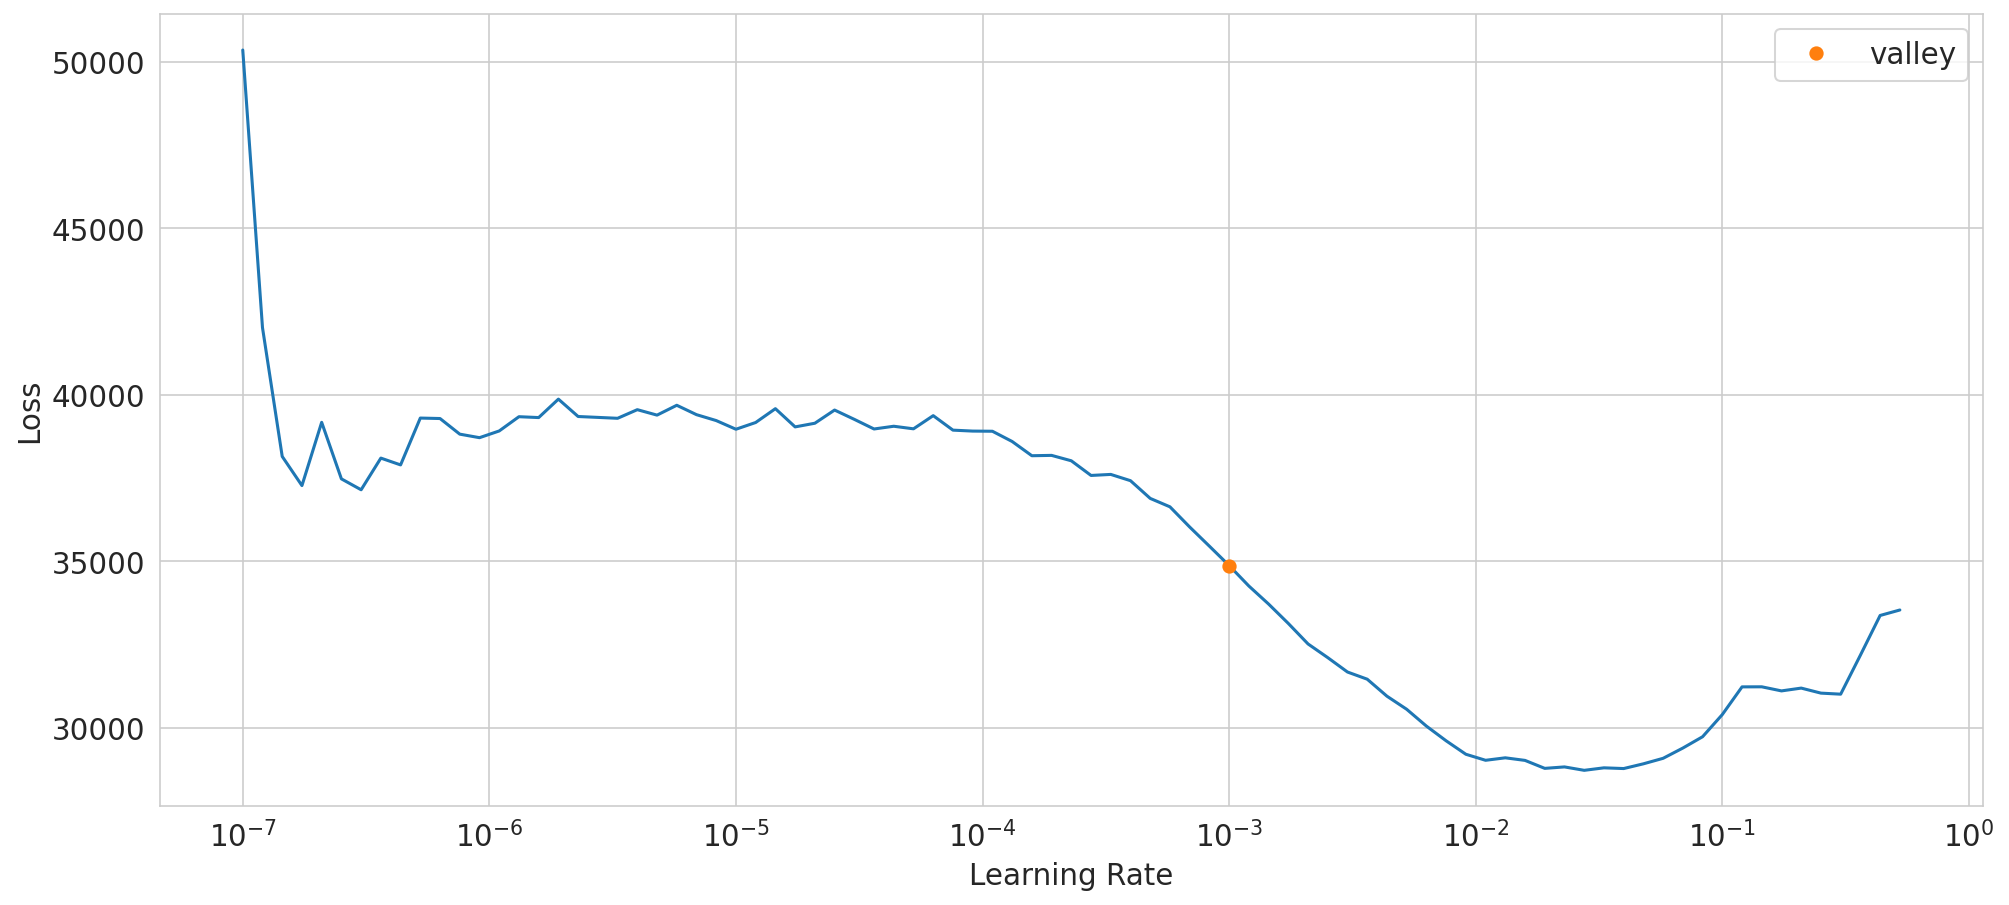

In [21]:
suggested_lr = analysis.learn.lr_find()
analysis.params['suggested_inital_lr'] = suggested_lr.valley
suggested_lr

dump model config

In [22]:
vaep.io.dump_json(analysis.params, args.out_models /
                  TEMPLATE_MODEL_PARAMS.format(args.model_key))

In [23]:
# papermill_description=train
analysis.learn.fit_one_cycle(args.epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,38913.699219,2730.078125,00:00
1,38302.144531,2716.752441,00:00
2,37543.675781,2678.621338,00:00
3,36729.609375,2592.197266,00:00
4,35823.613281,2465.716797,00:00
5,34734.675781,2301.922607,00:00
6,33697.847656,2123.451660,00:00
7,32551.761719,1944.770508,00:00
8,31166.091797,1771.035767,00:00
9,30103.812500,1590.654785,00:00


No improvement since epoch 24: early stopping


Save number of actually trained epochs

In [24]:
args.epoch_trained = analysis.learn.epoch + 1
args.epoch_trained

50

#### Loss normalized by total number of measurements

vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/dae_training


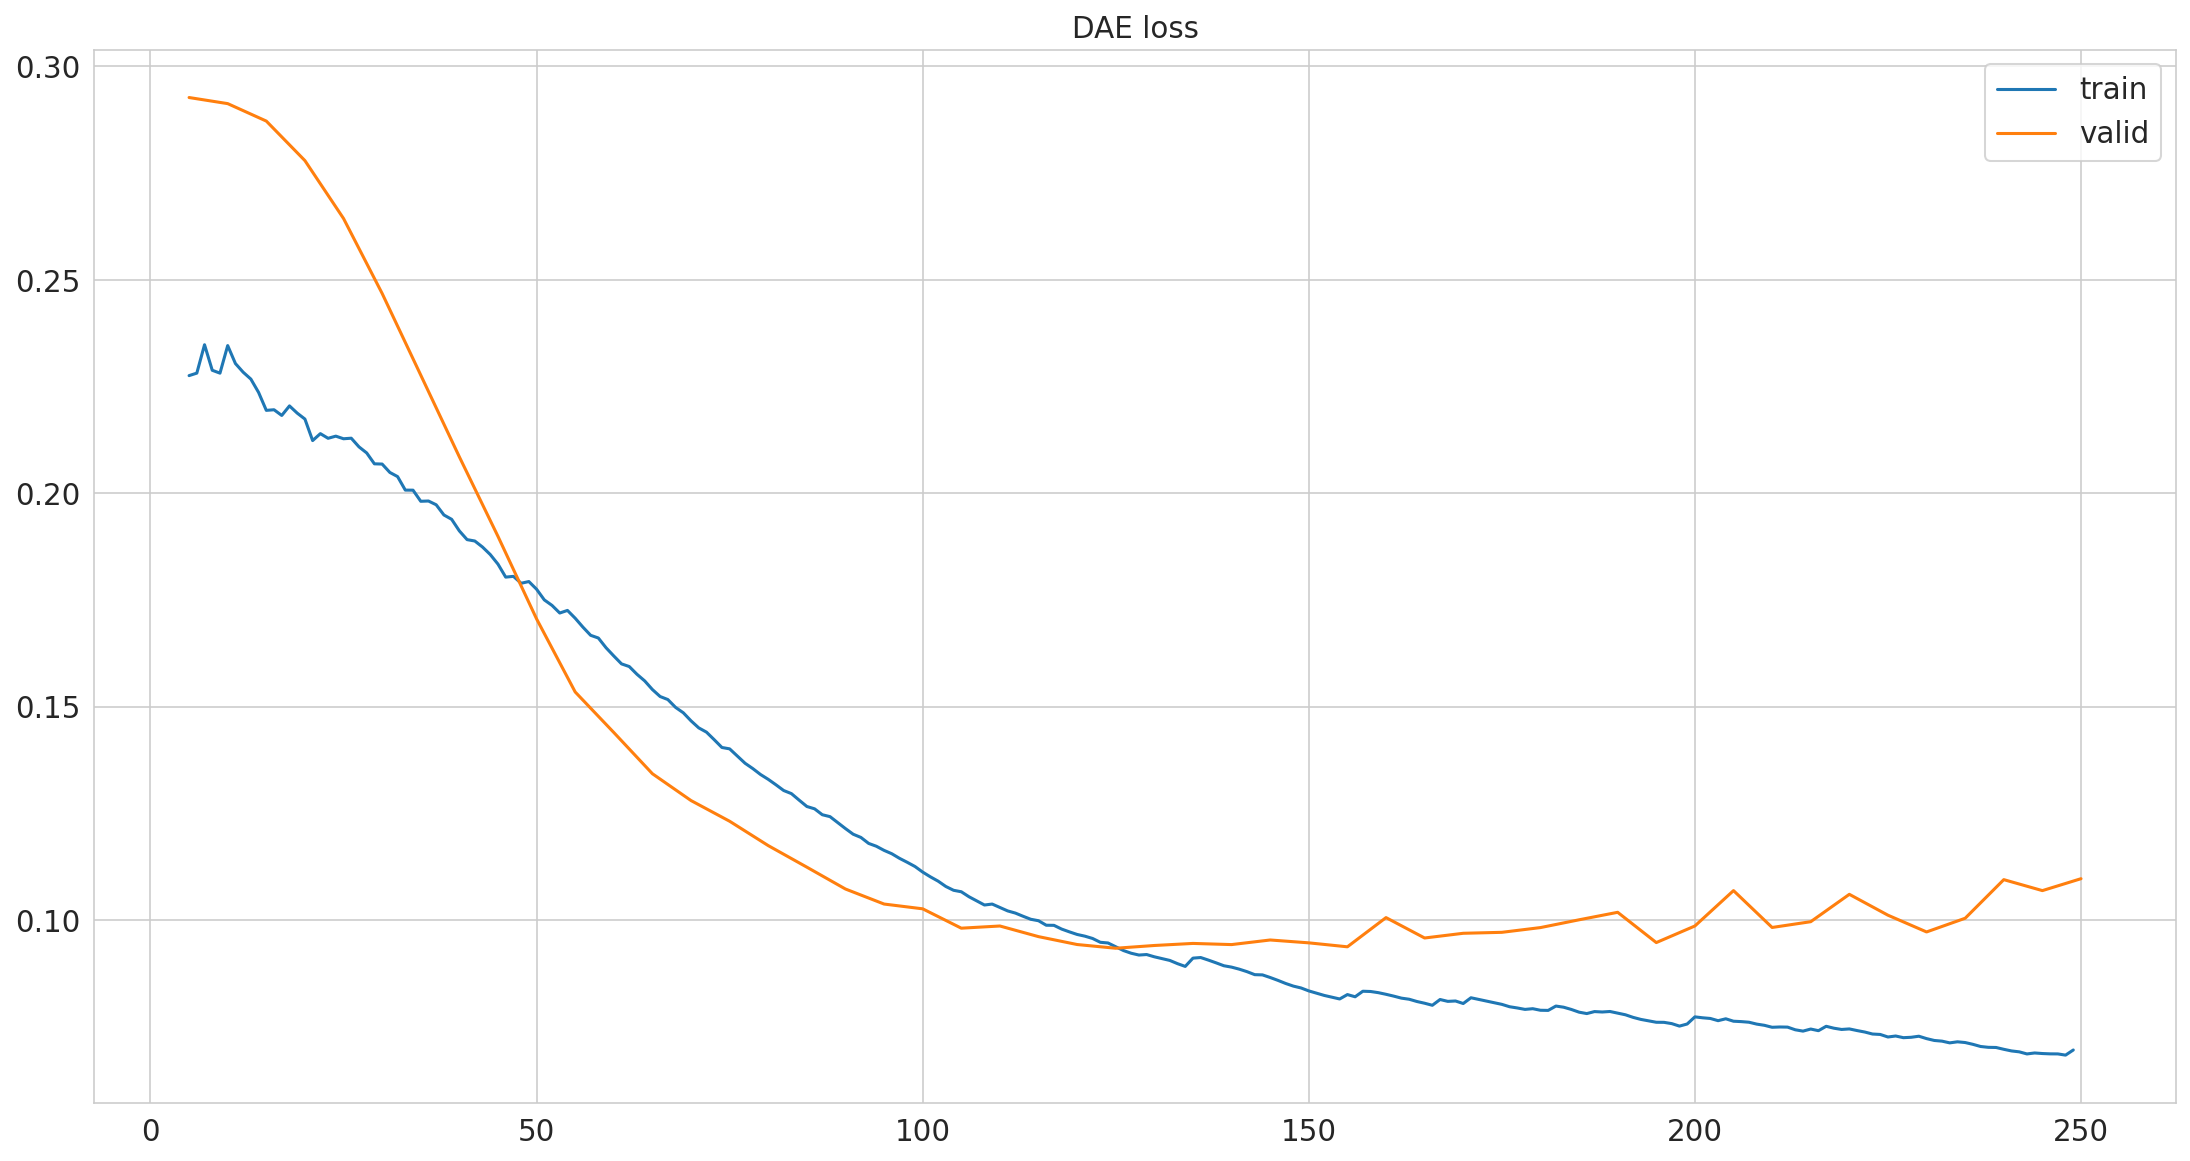

In [25]:
N_train_notna = data.train_X.notna().sum().sum()
N_val_notna = data.val_y.notna().sum().sum()
fig = models.plot_training_losses(analysis.learn, args.model_key,
                                  folder=args.out_figures,
                                  norm_factors=[N_train_notna, N_val_notna])

Why is the validation loss better then the training loss?
- during training input data is masked and needs to be reconstructed
- when evaluating the model, all input data is provided and only the artifically masked data is used for evaluation.

### Predictions

- data of training data set and validation dataset to create predictions is the same as training data.
- predictions include missing values (which are not further compared)

- [ ] double check ModelAdapter

create predictiona and select for validation data

In [26]:
analysis.model.eval()
pred, target = analysis.get_preds_from_df(df_wide=data.train_X)  # train_X
pred = pred.stack()
pred

Sample ID                                       Gene Names      
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  AAAS               27.717
                                                AACS               25.267
                                                AAMDC              25.304
                                                AAMP               26.289
                                                AAR2               26.595
                                                                    ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  ZWILCH             24.195
                                                ZWINT              26.659
                                                ZYX                29.618
                                                hCG_2014768;TMA7   28.874
                                                pk;ZAK             24.065
Length: 220250, dtype: float32

In [27]:
val_pred_simulated_na['DAE'] = pred  # model_key ?
val_pred_simulated_na

,,observed,DAE
Sample ID,Gene Names,,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180,26.601
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259,28.628
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629,31.018
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541,26.144
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934,33.348
...,...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717,28.279
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966,24.151
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654,25.252


In [28]:
test_pred_simulated_na['DAE'] = pred  # model_key?
test_pred_simulated_na

observed  \
Sample ID                                      Gene Names                   
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1               29.538   
                                               ACTN4               33.270   
                                               ADD3                24.259   
                                               ALCAM               24.906   
                                               ALDH1B1             26.674   
...                                                                   ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3               25.040   
                                               YTHDF3              28.717   
                                               ZC3H11A             28.935   
                                               ZFP91-CNTF;ZFP91    25.662   
                                               hCG_2014768;TMA7    29.212   

                                                                   DAE  
Sample ID                                      Gene Names               
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1            29.495  
                                               ACTN4            33.075  
                                               ADD3             24.863  
                                               ALCAM            24.613  
                                               ALDH1B1          26.342  
...                                                                ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3            25.578  
                                               YTHDF3           28.084  
                                               ZC3H11A          29.440  
                                               ZFP91-CNTF;ZFP91 26.947  
                                               hCG_2014768;TMA7 28.874  

[9327 rows x 2 columns]

save missing values predictions

In [29]:
if args.save_pred_real_na:
    pred_real_na = ae.get_missing_values(df_train_wide=data.train_X,
                                         val_idx=val_pred_simulated_na.index,
                                         test_idx=test_pred_simulated_na.index,
                                         pred=pred)
    display(pred_real_na)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

Sample ID                                       Gene Names 
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  AAMDC         25.304
                                                ABCB7         25.083
                                                ABCC4         23.482
                                                ABI2          24.741
                                                ACOT2;ACOT1   26.513
                                                               ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  ZNF346        24.834
                                                ZNF706        25.074
                                                ZNRF2         25.205
                                                ZWILCH        24.195
                                                pk;ZAK        24.065
Name: intensity, Length: 33698, dtype: float32

### Plots

- validation data

In [30]:
analysis.model.cpu()
df_latent = vaep.model.get_latent_space(analysis.model.encoder,
                                        dl=analysis.dls.valid,
                                        dl_index=analysis.dls.valid.data.index)
df_latent

,latent dimension 1,latent dimension 2,latent dimension 3,latent dimension 4,latent dimension 5,latent dimension 6,latent dimension 7,latent dimension 8,latent dimension 9,latent dimension 10
Sample ID,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,-0.064,-0.266,0.615,-0.442,-1.003,0.246,-0.777,1.722,-1.345,-0.530
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,1.770,0.342,0.454,-1.099,-2.274,-0.024,-0.260,1.766,-0.795,-0.136
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,0.126,1.003,0.421,-0.562,-0.107,0.204,-1.088,2.154,-0.693,0.069
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,1.479,-0.172,-0.051,-0.149,-2.756,0.360,-0.070,2.163,-1.259,-0.533
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,0.255,0.113,-2.667,0.768,1.705,0.190,0.540,-1.523,1.262,1.264
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,-0.255,0.561,-2.424,0.512,2.565,0.132,-0.064,-1.475,1.579,1.158
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,1.129,-0.491,-1.486,1.915,-3.184,0.088,2.675,-4.372,-0.734,-0.073
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,0.526,0.788,-1.166,1.417,-2.137,-1.420,0.394,-4.592,-0.397,1.016
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,1.283,1.505,-2.378,-0.083,1.568,0.544,0.553,-3.515,0.545,1.168


In [31]:
# ! calculate embeddings only if meta data is available? Optional argument to save embeddings?
ana_latent = analyzers.LatentAnalysis(df_latent,
                                      df_meta,
                                      args.model_key,
                                      folder=args.out_figures)
if args.meta_date_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_date'], ax = ana_latent.plot_by_date(
        args.meta_date_col)

In [32]:
if args.meta_cat_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_{"_".join(args.meta_cat_col.split())}'], ax = ana_latent.plot_by_category(
        args.meta_cat_col)

## Comparisons

Simulated NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

### Validation data

- all measured (identified, observed) peptides in validation data

In [33]:
# papermill_description=metrics
d_metrics = models.Metrics()

The simulated NA for the validation step are real test data (not used for training nor early stopping)

In [34]:
added_metrics = d_metrics.add_metrics(val_pred_simulated_na, 'valid_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'DAE': {'MSE': 0.9048345044227847,
  'MAE': 0.6714483148513914,
  'N': 9327,
  'prop': 1.0}}

### Test Datasplit

In [35]:
added_metrics = d_metrics.add_metrics(test_pred_simulated_na, 'test_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'DAE': {'MSE': 0.9132345876795329,
  'MAE': 0.6676449698577884,
  'N': 9327,
  'prop': 1.0}}

Save all metrics as json

In [36]:
vaep.io.dump_json(d_metrics.metrics, args.out_metrics /
                  f'metrics_{args.model_key}.json')
d_metrics

{ 'test_simulated_na': { 'DAE': { 'MAE': 0.6676449698577884,
                                  'MSE': 0.9132345876795329,
                                  'N': 9327,
                                  'prop': 1.0}},
  'valid_simulated_na': { 'DAE': { 'MAE': 0.6714483148513914,
                                   'MSE': 0.9048345044227847,
                                   'N': 9327,
                                   'prop': 1.0}}}

In [37]:
metrics_df = models.get_df_from_nested_dict(d_metrics.metrics,
                                            column_levels=['model', 'metric_name']).T
metrics_df

subset             valid_simulated_na  test_simulated_na
model metric_name                                       
DAE   MSE                       0.905              0.913
      MAE                       0.671              0.668
      N                     9,327.000          9,327.000
      prop                      1.000              1.000

## Save predictions

In [38]:
# save simulated missing values for both splits
val_pred_simulated_na.to_csv(args.out_preds / f"pred_val_{args.model_key}.csv")
test_pred_simulated_na.to_csv(args.out_preds / f"pred_test_{args.model_key}.csv")

## Config

In [39]:
figures  # switch to fnames?

{}

In [40]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 4405,
 'batch_size': 10,
 'cuda': False,
 'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'epoch_trained': 50,
 'epochs_max': 200,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'hidden_layers': [512],
 'latent_dim': 10,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'DAE',
 'model_key': 'DAE',
 'n_params': 4528447,
 'out_figures': Path('runs/dev_dataset_small/proteinGroups_N50/figures'),
 'out_folder': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_metrics': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_models': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_preds': Path('runs/dev_dataset_small/proteinGroups_N50/preds'),
 'patience': 25,
 'sample_idx_position': 0,
 'save_pred_real_na': True}